In [1]:
import os
os.chdir(r'C:\Users\nicol\Desktop\dataSet\utils')

In [3]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

from PIL.ExifTags import TAGS
from engine import train_one_epoch, evaluate
import utils
from torchvision import transforms as T 

In [4]:
class DataSet(torch.utils.data.Dataset):
    
    def __init__(self,root, data_file, transform):
        self.root = root ### mapa cu fotografii
        self.transform = transform
        self.data = pd.read_csv(data_file, sep=',')
        self.imgs = self.data['image_path'].values
        self.path_to_data_file = data_file
        
    def __getitem__(self,idx):
        
        img_path = os.path.join(self.root,self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        
        for orientation in TAGS.keys() : 
            if TAGS[orientation]=='Orientation' : break 
        # Getting the exif
        exif=dict(img.getexif().items())
        # Rotating the image if the orientation is wrong.
        if len(exif)!=0:                                                             
            if orientation in exif.keys():
                if exif[orientation] == 3 : 
                    img=img.rotate(180, expand=True)
                elif exif[orientation] == 6 : 
                    img=img.rotate(270, expand=True)
                elif exif[orientation] == 8 : 
                    img=img.rotate(90, expand=True)
                    
        box_list = self.data[self.data['image_path']==self.imgs[idx]][['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_obj = len(box_list)
        labels = torch.ones((num_obj,), dtype = torch.int64)
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])
        
        image_id = torch.tensor([idx])
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = image_id
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return len(self.data)

In [5]:
transformations = T.Compose([T.ToTensor()])

dataset = DataSet(r'C:\Users\nicol\Desktop\dataSet',
                  r'C:\Users\nicol\Desktop\dataSet\dataSetR.csv',
                  transformations)

torch.manual_seed(1)

indices = torch.randperm(len(dataset)).tolist()
train = torch.utils.data.Subset(dataset, indices[:100])
test = torch.utils.data.Subset(dataset, indices[100:])

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True, collate_fn = utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False, collate_fn = utils.collate_fn)

In [6]:
def get_model(num_clase):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    for param in model.parameters():
        param.required_grad = False
        
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_clase)
    
    return model

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

num_clase = 2
model = get_model(num_clase).to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.005, momentum=0.9, weight_decay = 0.0005) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\nicol/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [9]:
num_epoch = 5

for epoch in range(num_epoch):
    
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, print_freq = 10)
    
    evaluate(model, test_loader, device=DEVICE)

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/100]  eta: 0:14:48  lr: 0.000055  loss: 0.9414 (0.9414)  loss_classifier: 0.6885 (0.6885)  loss_box_reg: 0.2441 (0.2441)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 8.8820  data: 0.0974  max mem: 976
Epoch: [0]  [ 10/100]  eta: 0:01:33  lr: 0.000560  loss: 0.6092 (0.6202)  loss_classifier: 0.4466 (0.4642)  loss_box_reg: 0.1122 (0.1141)  loss_objectness: 0.0111 (0.0357)  loss_rpn_box_reg: 0.0071 (0.0062)  time: 1.0432  data: 0.0289  max mem: 1617
Epoch: [0]  [ 20/100]  eta: 0:00:53  lr: 0.001065  loss: 0.3466 (0.4564)  loss_classifier: 0.1914 (0.3171)  loss_box_reg: 0.0947 (0.1101)  loss_objectness: 0.0061 (0.0241)  loss_rpn_box_reg: 0.0046 (0.0052)  time: 0.2564  data: 0.0200  max mem: 1622
Epoch: [0]  [ 30/100]  eta: 0:00:37  lr: 0.001569  loss: 0.2733 (0.4049)  loss_classifier: 0.1345 (0.2604)  loss_box_reg: 0.1087 (0.1158)  loss_objectness: 0.0134 (0.0235)  loss_rpn_box_reg: 0.0034 (0.0052)  time: 0.2563  data: 0.0171  max mem: 1623
E

Epoch: [2]  [  0/100]  eta: 0:00:20  lr: 0.005000  loss: 0.0607 (0.0607)  loss_classifier: 0.0153 (0.0153)  loss_box_reg: 0.0298 (0.0298)  loss_objectness: 0.0144 (0.0144)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.2047  data: 0.0090  max mem: 1662
Epoch: [2]  [ 10/100]  eta: 0:00:21  lr: 0.005000  loss: 0.0803 (0.0851)  loss_classifier: 0.0204 (0.0247)  loss_box_reg: 0.0366 (0.0376)  loss_objectness: 0.0144 (0.0209)  loss_rpn_box_reg: 0.0011 (0.0019)  time: 0.2367  data: 0.0115  max mem: 1662
Epoch: [2]  [ 20/100]  eta: 0:00:19  lr: 0.005000  loss: 0.0723 (0.0720)  loss_classifier: 0.0185 (0.0219)  loss_box_reg: 0.0301 (0.0320)  loss_objectness: 0.0035 (0.0154)  loss_rpn_box_reg: 0.0011 (0.0026)  time: 0.2498  data: 0.0108  max mem: 1662
Epoch: [2]  [ 30/100]  eta: 0:00:17  lr: 0.005000  loss: 0.0505 (0.0667)  loss_classifier: 0.0157 (0.0210)  loss_box_reg: 0.0263 (0.0318)  loss_objectness: 0.0010 (0.0116)  loss_rpn_box_reg: 0.0012 (0.0022)  time: 0.2651  data: 0.0103  max mem: 1662


Epoch: [4]  [  0/100]  eta: 0:00:27  lr: 0.005000  loss: 0.0401 (0.0401)  loss_classifier: 0.0127 (0.0127)  loss_box_reg: 0.0262 (0.0262)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 0.2716  data: 0.0060  max mem: 1662
Epoch: [4]  [ 10/100]  eta: 0:00:21  lr: 0.005000  loss: 0.0301 (0.0324)  loss_classifier: 0.0093 (0.0089)  loss_box_reg: 0.0223 (0.0215)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0013)  time: 0.2337  data: 0.0118  max mem: 1662
Epoch: [4]  [ 20/100]  eta: 0:00:19  lr: 0.005000  loss: 0.0301 (0.0349)  loss_classifier: 0.0085 (0.0096)  loss_box_reg: 0.0208 (0.0227)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0019)  time: 0.2373  data: 0.0105  max mem: 1662
Epoch: [4]  [ 30/100]  eta: 0:00:16  lr: 0.005000  loss: 0.0301 (0.0335)  loss_classifier: 0.0085 (0.0099)  loss_box_reg: 0.0191 (0.0216)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0003 (0.0015)  time: 0.2446  data: 0.0096  max mem: 1662


In [10]:
torch.save(model.state_dict(),r'C:\Users\nicol\Desktop\dataSet\savedModel\md_stema.pth')

In [11]:
loaded_model = get_model(num_clase=2)
loaded_model.load_state_dict(torch.load(r'C:\Users\nicol\Desktop\dataSet\savedModel\md_stema.pth'))

<All keys matched successfully>

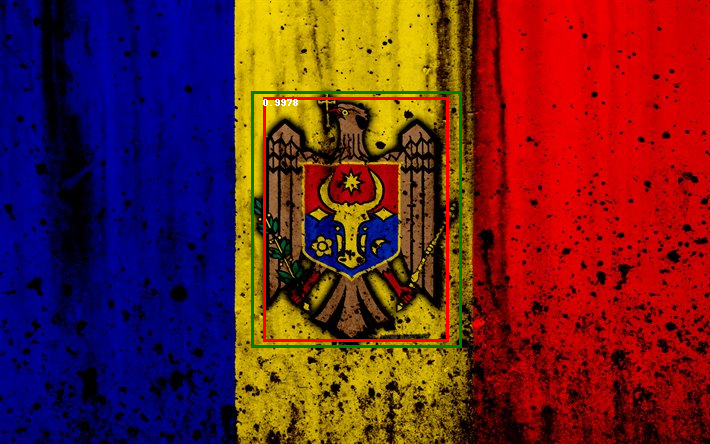

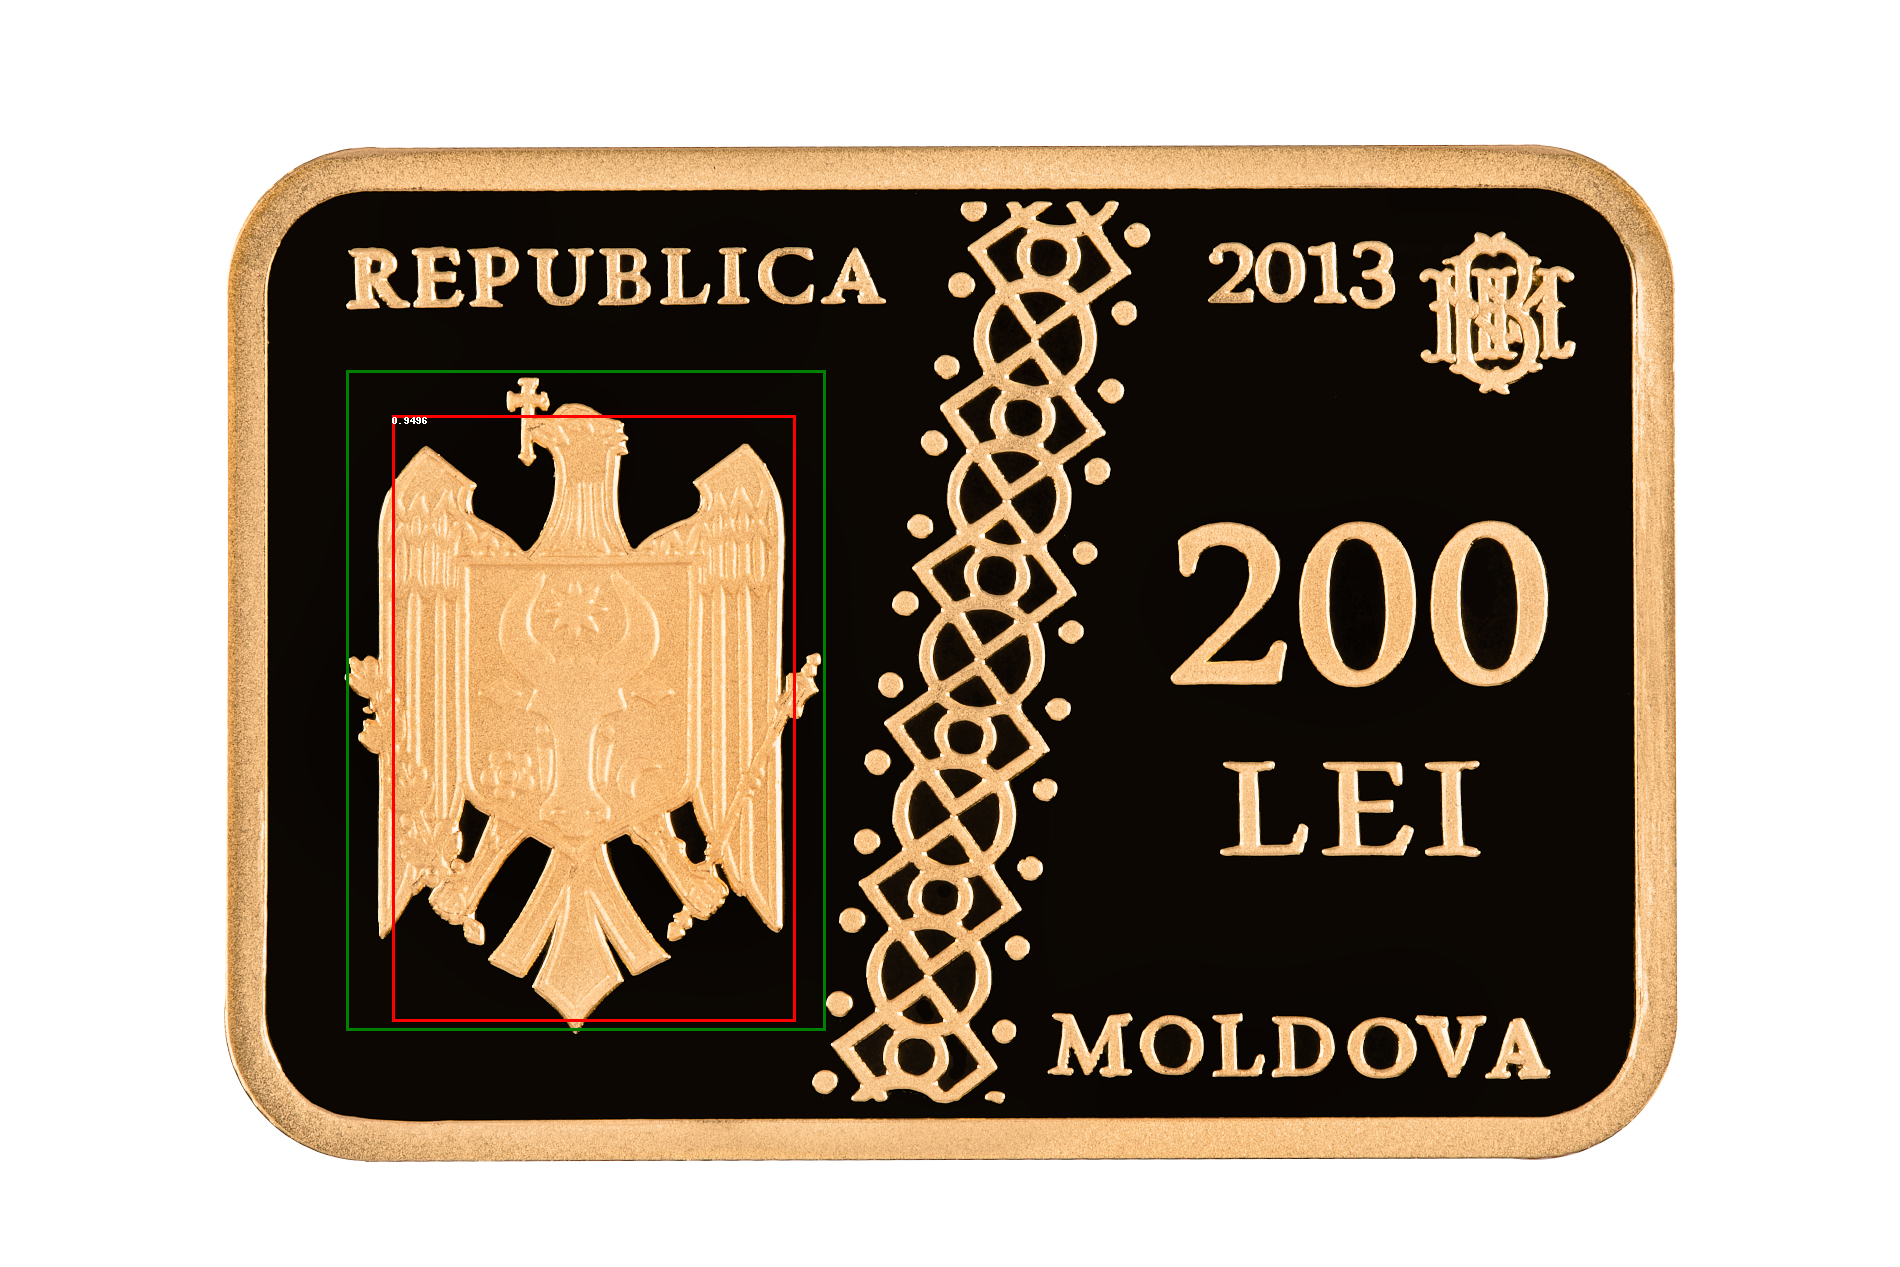

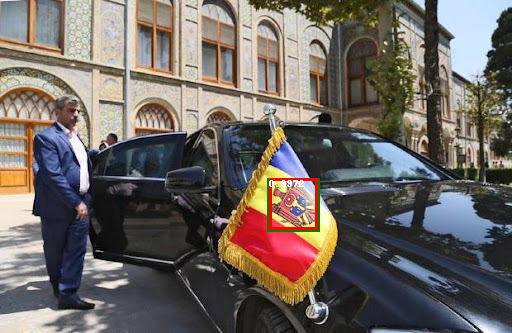

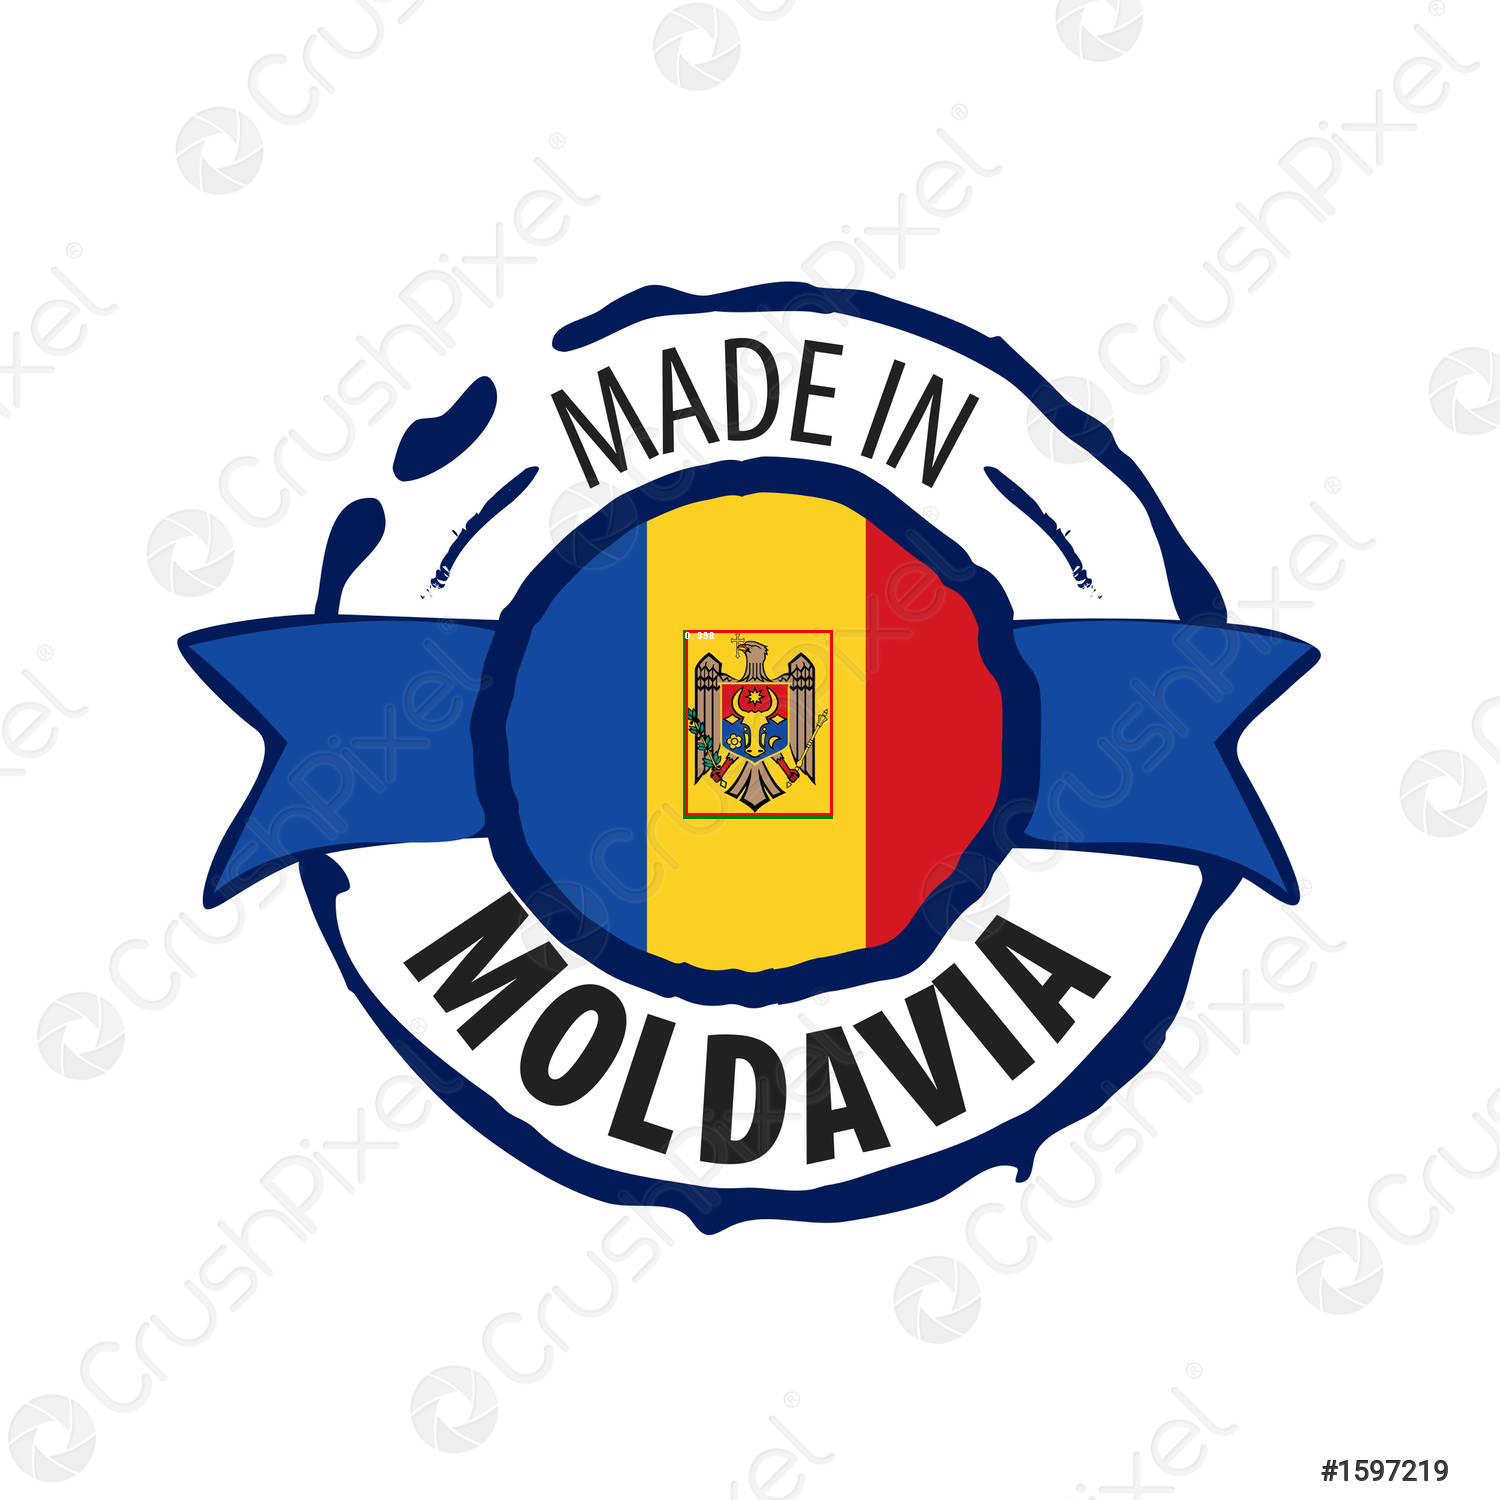

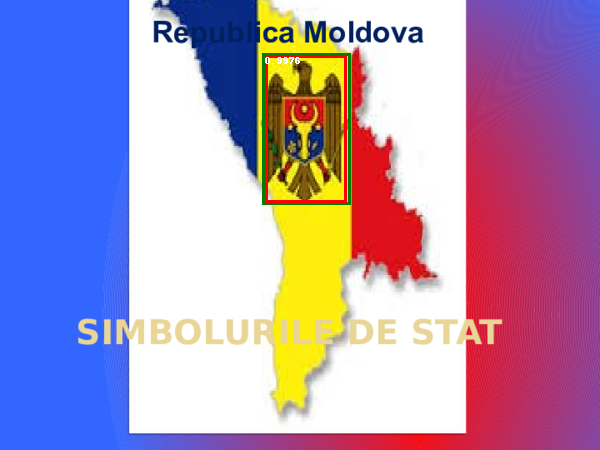

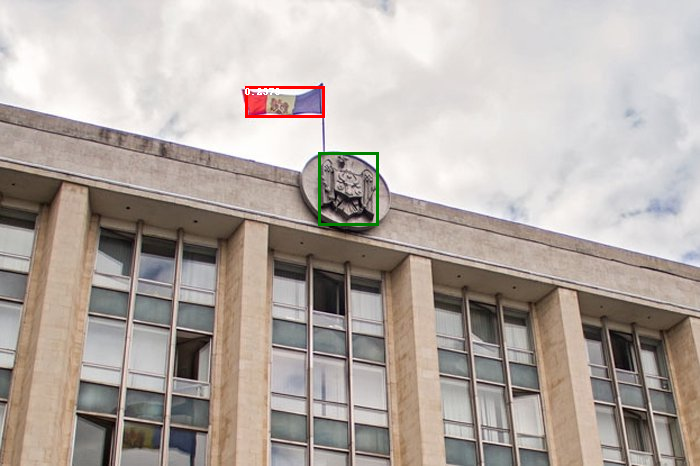

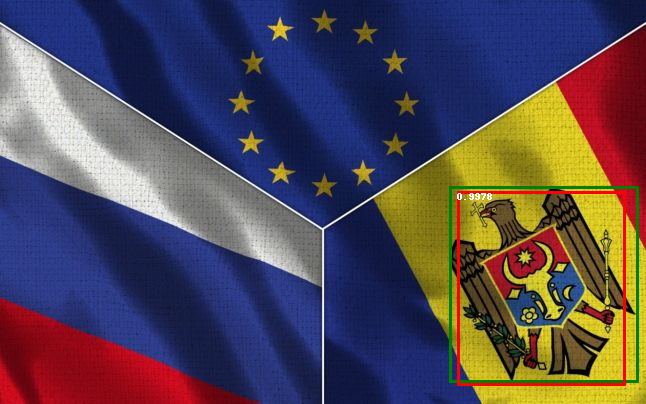

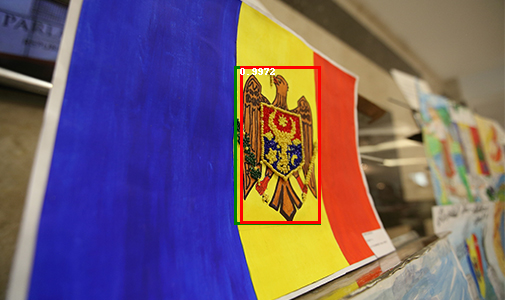

In [18]:
# Use this code to made a predition.
from PIL import ImageDraw
# Getting the image.
for idx in range(2,18):
    img, _ = test[idx]
    # Getting the object coordinates.
    label_boxes = np.array(test[idx][1]['boxes'])

    # Setting the model to eval state.
    loaded_model.eval()
    # Making the prediction.
    with torch.no_grad():
        prediction = loaded_model([img])

    # Getting an drawing the image.
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)

    # Drawing the real box around the object.
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                       (label_boxes[elem][2], label_boxes[elem][3])],
                      outline='green', width=3)
    # Drawing the predicted box around the object.
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()                                     
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=4)

        if score > 0.2:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                         outline='red', width=3)
            draw.text((boxes[0], boxes[1]), text=str(score))
    display(image)